In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [9]:
# pickle에서 데이터프레임 다시 불러오기
with open('df.pickle', 'rb') as f:
    df = pickle.load(f)

### Feature Engineering

In [ ]:
# df['공시가격리스트']= df['공시가격리스트'].astype(str)
df.drop(['공시가격리스트', '지하철역세권', '버스정류장세권'], axis=1, inplace=True)
df['평균공시가격']=df['평균공시가격'].interpolate(method='linear', axis=0)

In [10]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격'],
      dtype='object')

### Train

In [12]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 14) (9272, 14)


In [13]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '구', '동', '계약년', '계약월']


In [14]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


In [15]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [16]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    num_leaves = trial.suggest_int('num_leaves', 100, 1000)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

    # Create the LGBMRegressor model with the suggested hyperparameters
    gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
                            min_child_samples=min_child_samples, feature_fraction=feature_fraction,
                            bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

    # Train the model
    gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
    
    # Compute the validation RMSE
    val_rmse = gbm.best_score_['valid_1']['rmse']
    return val_rmse

def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = lgb.LGBMRegressor(**best_params)

    # Train the final model with early stopping and evaluation logging
    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
                              lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

    return best_model

In [17]:
best_model = optimize_hyperparameters(n_trials=5)

[I 2024-03-28 09:38:42,903] A new study created in memory with name: no-name-2abec9cb-b46a-4172-9996-a596634c6348


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5169.92	training's l2: 2.67281e+07	valid_1's rmse: 6184.02	valid_1's l2: 3.82421e+07
[200]	training's rmse: 4386.87	training's l2: 1.92447e+07	valid_1's rmse: 5804.44	valid_1's l2: 3.36915e+07
[300]	training's rmse: 3993.24	training's l2: 1.5946e+07	valid_1's rmse: 5693.47	valid_1's l2: 3.24156e+07
[400]	training's rmse: 3719.13	training's l2: 1.38319e+07	valid_1's rmse: 5647.07	valid_1's l2: 3.18894e+07
[500]	training's rmse: 3518.52	training's l2: 1.238e+07	valid_1's rmse: 5619.33	valid_1's l2: 3.15768e+07
[600]	training's rmse: 3352.32	training's l2: 1.12381e+07	valid_1's rmse: 5608.19	valid_1's l2: 3.14518e+07
[700]	training's rmse: 3206.46	training's l2: 1.02814e+07	valid_1's rmse: 5599.92	valid_1's l2: 3.13591e+07
Early stopping, best iteration is:
[707]	training's rmse: 3199.67	training's l2: 1.02379e+07	valid_1's rmse: 5598.28	valid_1's l2: 3.13407e+07


[I 2024-03-28 09:39:11,803] Trial 0 finished with value: 5598.279882656738 and parameters: {'n_estimators': 2510, 'max_depth': 25, 'num_leaves': 855, 'min_child_samples': 51, 'feature_fraction': 0.8407470372531338, 'bagging_fraction': 0.7803757472839843, 'lambda_l1': 0.00023665934828538617, 'lambda_l2': 0.18520109431461257}. Best is trial 0 with value: 5598.279882656738.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6963.73	training's l2: 4.84935e+07	valid_1's rmse: 7339.66	valid_1's l2: 5.38706e+07
[200]	training's rmse: 6093.93	training's l2: 3.71359e+07	valid_1's rmse: 6617.83	valid_1's l2: 4.37956e+07
[300]	training's rmse: 5668.07	training's l2: 3.2127e+07	valid_1's rmse: 6299.93	valid_1's l2: 3.96891e+07
[400]	training's rmse: 5395.51	training's l2: 2.91115e+07	valid_1's rmse: 6121.65	valid_1's l2: 3.74746e+07
[500]	training's rmse: 5193.26	training's l2: 2.69699e+07	valid_1's rmse: 5995.68	valid_1's l2: 3.59482e+07
[600]	training's rmse: 5035.03	training's l2: 2.53516e+07	valid_1's rmse: 5903.96	valid_1's l2: 3.48568e+07
[700]	training's rmse: 4902.54	training's l2: 2.40349e+07	valid_1's rmse: 5834.69	valid_1's l2: 3.40436e+07
[800]	training's rmse: 4783.46	training's l2: 2.28815e+07	valid_1's rmse: 5780.15	valid_1's l2: 3.34102e+07
[900]	training's rmse: 4676.7	training's l2: 2.18716e+07	valid_1's rmse: 573

[I 2024-03-28 09:39:58,769] Trial 1 finished with value: 5530.05823486167 and parameters: {'n_estimators': 3018, 'max_depth': 35, 'num_leaves': 299, 'min_child_samples': 282, 'feature_fraction': 0.9592111410711301, 'bagging_fraction': 0.6666926617089871, 'lambda_l1': 5.5208157879714006e-05, 'lambda_l2': 1.9910789868692976e-07}. Best is trial 1 with value: 5530.05823486167.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7173.55	training's l2: 5.14599e+07	valid_1's rmse: 7577.61	valid_1's l2: 5.74201e+07
[200]	training's rmse: 6453.37	training's l2: 4.1646e+07	valid_1's rmse: 6926.32	valid_1's l2: 4.79739e+07
[300]	training's rmse: 6067.18	training's l2: 3.68106e+07	valid_1's rmse: 6600.28	valid_1's l2: 4.35637e+07
[400]	training's rmse: 5819.1	training's l2: 3.38619e+07	valid_1's rmse: 6402.93	valid_1's l2: 4.09975e+07
[500]	training's rmse: 5631.59	training's l2: 3.17148e+07	valid_1's rmse: 6266.2	valid_1's l2: 3.92653e+07
[600]	training's rmse: 5482.53	training's l2: 3.00582e+07	valid_1's rmse: 6156.64	valid_1's l2: 3.79042e+07
[700]	training's rmse: 5365.77	training's l2: 2.87915e+07	valid_1's rmse: 6079.71	valid_1's l2: 3.69629e+07
[800]	training's rmse: 5260.95	training's l2: 2.76776e+07	valid_1's rmse: 6017.87	valid_1's l2: 3.62148e+07
[900]	training's rmse: 5172.65	training's l2: 2.67563e+07	valid_1's rmse: 5967

[I 2024-03-28 09:40:50,282] Trial 2 finished with value: 5633.2428980216055 and parameters: {'n_estimators': 3013, 'max_depth': 17, 'num_leaves': 952, 'min_child_samples': 373, 'feature_fraction': 0.9498075226750793, 'bagging_fraction': 0.59117298004789, 'lambda_l1': 0.00010238565136602412, 'lambda_l2': 4.215862576048331e-06}. Best is trial 1 with value: 5530.05823486167.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7297.23	training's l2: 5.32496e+07	valid_1's rmse: 7698.74	valid_1's l2: 5.92706e+07
[200]	training's rmse: 6482.46	training's l2: 4.20223e+07	valid_1's rmse: 6970.61	valid_1's l2: 4.85895e+07
[300]	training's rmse: 6058.06	training's l2: 3.67001e+07	valid_1's rmse: 6622.42	valid_1's l2: 4.38565e+07
[400]	training's rmse: 5777.84	training's l2: 3.33834e+07	valid_1's rmse: 6419.77	valid_1's l2: 4.12135e+07
[500]	training's rmse: 5574.64	training's l2: 3.10766e+07	valid_1's rmse: 6285.12	valid_1's l2: 3.95027e+07
[600]	training's rmse: 5407.38	training's l2: 2.92398e+07	valid_1's rmse: 6181.45	valid_1's l2: 3.82104e+07
[700]	training's rmse: 5271.81	training's l2: 2.7792e+07	valid_1's rmse: 6100.85	valid_1's l2: 3.72204e+07
[800]	training's rmse: 5155.37	training's l2: 2.65778e+07	valid_1's rmse: 6031.63	valid_1's l2: 3.63806e+07
[900]	training's rmse: 5053.17	training's l2: 2.55345e+07	valid_1's rmse: 59

[I 2024-03-28 09:41:52,060] Trial 3 finished with value: 5740.047066435013 and parameters: {'n_estimators': 1728, 'max_depth': 39, 'num_leaves': 989, 'min_child_samples': 487, 'feature_fraction': 0.9746757802324266, 'bagging_fraction': 0.9242736342607145, 'lambda_l1': 3.720254767133898e-05, 'lambda_l2': 1.5002527580161077e-07}. Best is trial 1 with value: 5530.05823486167.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6659.82	training's l2: 4.43531e+07	valid_1's rmse: 7124.54	valid_1's l2: 5.07591e+07
[200]	training's rmse: 5818.44	training's l2: 3.38542e+07	valid_1's rmse: 6466.92	valid_1's l2: 4.18211e+07
[300]	training's rmse: 5412.25	training's l2: 2.92925e+07	valid_1's rmse: 6178.91	valid_1's l2: 3.81789e+07
[400]	training's rmse: 5168.93	training's l2: 2.67178e+07	valid_1's rmse: 6023.04	valid_1's l2: 3.62771e+07
[500]	training's rmse: 4983.34	training's l2: 2.48337e+07	valid_1's rmse: 5923.61	valid_1's l2: 3.50891e+07
[600]	training's rmse: 4837.18	training's l2: 2.33983e+07	valid_1's rmse: 5862.52	valid_1's l2: 3.43691e+07
[700]	training's rmse: 4728.2	training's l2: 2.23558e+07	valid_1's rmse: 5813.87	valid_1's l2: 3.38011e+07
[800]	training's rmse: 4626.23	training's l2: 2.1402e+07	valid_1's rmse: 5779.55	valid_1's l2: 3.34032e+07
[900]	training's rmse: 4531.27	training's l2: 2.05324e+07	valid_1's rmse: 575

[I 2024-03-28 09:42:27,438] Trial 4 finished with value: 5600.7362682284065 and parameters: {'n_estimators': 4436, 'max_depth': 14, 'num_leaves': 251, 'min_child_samples': 120, 'feature_fraction': 0.8883064919419235, 'bagging_fraction': 0.7457023584127582, 'lambda_l1': 0.00037733126515602193, 'lambda_l2': 5.4048215421845396e-05}. Best is trial 1 with value: 5530.05823486167.


[LightGBM] [Warning] feature_fraction is set=0.9592111410711301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592111410711301
[LightGBM] [Warning] lambda_l2 is set=1.9910789868692976e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9910789868692976e-07
[LightGBM] [Warning] lambda_l1 is set=5.5208157879714006e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5208157879714006e-05
[LightGBM] [Warning] bagging_fraction is set=0.6666926617089871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666926617089871
[LightGBM] [Warning] feature_fraction is set=0.9592111410711301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592111410711301
[LightGBM] [Warning] lambda_l2 is set=1.9910789868692976e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9910789868692976e-07
[LightGBM] [Warning] lambda_l1 is set=5.5208157879714006e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.

In [18]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = best_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('baseline3.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.9592111410711301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592111410711301
[LightGBM] [Warning] lambda_l2 is set=1.9910789868692976e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9910789868692976e-07
[LightGBM] [Warning] lambda_l1 is set=5.5208157879714006e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5208157879714006e-05
[LightGBM] [Warning] bagging_fraction is set=0.6666926617089871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666926617089871


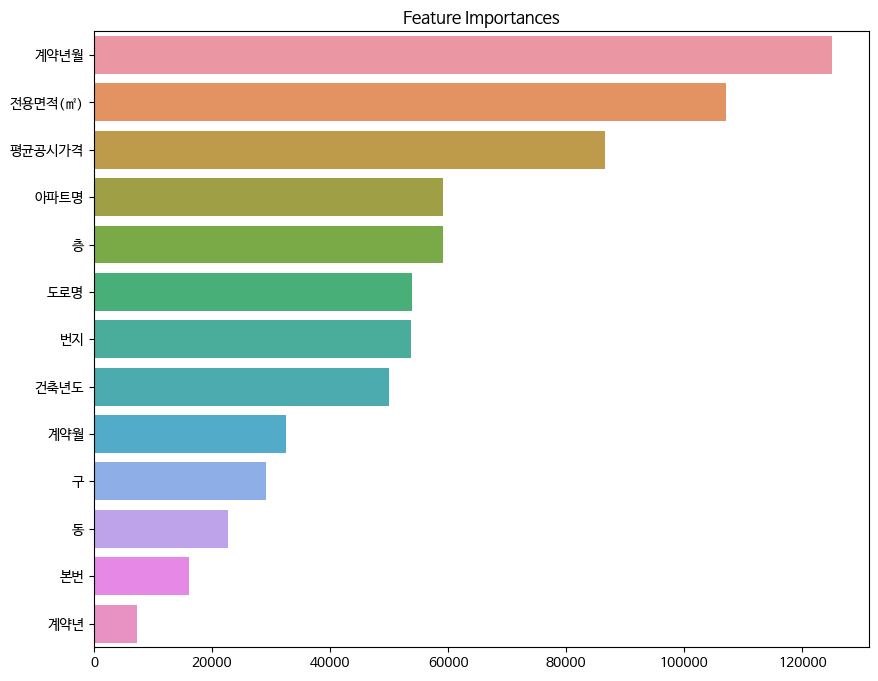

In [19]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()